In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [2]:
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [3]:
#Hente data og sette til array
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

# print(bhArray.shape)
# print(sphArray.shape)

In [4]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

# np.shape(dataArray)

In [5]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [6]:
#Sjekker hvis GPU er brukt
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [7]:
#Split data 75% i train og 25% i test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [8]:
#Transformere data frå numpy array til torch
trainData = torch.from_numpy(trainData)
testData = torch.from_numpy(testData)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [9]:
#Transformere numpy til tensor
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [10]:
#Sette data til å vere dataloaders
trainLoader = DataLoader(train, shuffle=True, batch_size=50)
testLoader = DataLoader(test, shuffle=True, batch_size=50)

In [11]:
class SymmetricNet(nn.Module):
    def __init__(self, dropout):
        super(SymmetricNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, 3) #first layer
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv2d(128, 256, 4) #second layer
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.AvgPool2d(2, 2)
        self.dropout2 = nn.Dropout(dropout)
        
        self.conv3 = nn.Conv2d(256, 512, 3) #third layer
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.AvgPool2d(2, 2)
        self.dropout3 = nn.Dropout(dropout)
        
        self.conv4 = nn.Conv2d(512, 1024, 5, padding=2) #fourth layer
        self.bn4 = nn.BatchNorm2d(1024)
        self.pool4 = nn.AvgPool2d(2, 2)
        self.dropout4 = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear(1024 * 2 * 2, 256)
        self.dropout5 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x_flipped_horizontal = torch.flip(x, [3]) #flip horizontally
        x_flipped_vertical = torch.flip(x, [2]) #flip vertically
        x_rotated_180 = torch.rot90(x, 2, [2,3])#rotate 180
        
        x = F.relu(self.bn1(self.conv1(x)))
        x_flipped_horizontal = F.relu(self.bn1(self.conv1(x_flipped_horizontal)))
        x_flipped_vertical = F.relu(self.bn1(self.conv1(x_flipped_vertical)))
        x_rotated_180 = F.relu(self.bn1(self.conv1(x_rotated_180)))
        
        x = self.pool1(x)
        x_flipped_horizontal = self.pool1(x_flipped_horizontal)
        x_flipped_vertical = self.pool1(x_flipped_vertical)
        x_rotated_180 = self.pool1(x_rotated_180)
        
        x = (x + x_flipped_vertical + x_rotated_180) / 3
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        x = x.reshape(-1, 1024 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)
        
        x = self.fc2(x)
        return x


In [12]:
from torchsummary import summary

model = SymmetricNet(dropout=0.25).to(device)  # Move the model to the appropriate device

# Print the model summary, make sure to provide appropriate input size (3, 50, 50) for the 3-channel 50x50 images
summary(model, input_size=(3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           3,584
       BatchNorm2d-2          [-1, 128, 48, 48]             256
            Conv2d-3          [-1, 128, 48, 48]           3,584
       BatchNorm2d-4          [-1, 128, 48, 48]             256
            Conv2d-5          [-1, 128, 48, 48]           3,584
       BatchNorm2d-6          [-1, 128, 48, 48]             256
         AvgPool2d-7          [-1, 128, 24, 24]               0
         AvgPool2d-8          [-1, 128, 24, 24]               0
         AvgPool2d-9          [-1, 128, 24, 24]               0
          Dropout-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 21, 21]         524,544
      BatchNorm2d-12          [-1, 256, 21, 21]             512
        AvgPool2d-13          [-1, 256, 10, 10]               0
          Dropout-14          [-1, 256,

In [13]:
def train(model, train_loader, test_loader, optimizer, criterion, n_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Initialize lists to store the metrics
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    #Start epoch
    for epoch in range(n_epochs):
        # Train
        model.train()
        train_loss = 0
        correct = 0
        total = 0
    
        #Train loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True).float(), labels.to(device, non_blocking=True).long()
            optimizer.zero_grad()
            outputs = model(inputs.permute(0, 3, 1, 2)).float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        #Train loop end
        

        train_acc = 100 * correct / total
        train_loss /= len(train_loader)

        # Test
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device, non_blocking=True).float(), labels.to(device, non_blocking=True).long()
                outputs = model(inputs.permute(0, 3, 1, 2)).float()
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_acc = 100 * correct / total
        test_loss /= len(test_loader)

        # Print results
        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

        # Append the metrics to the lists
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    # Plot the metrics
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.legend()
    plt.title('Training and Testing Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.show()


Epoch 1/15
Train Loss: 0.3587, Train Accuracy: 85.13%
Test Loss: 0.2591, Test Accuracy: 89.36%
Epoch 2/15
Train Loss: 0.2917, Train Accuracy: 88.40%
Test Loss: 0.2631, Test Accuracy: 89.73%
Epoch 3/15
Train Loss: 0.2791, Train Accuracy: 89.03%
Test Loss: 0.2374, Test Accuracy: 90.36%
Epoch 4/15
Train Loss: 0.2591, Train Accuracy: 89.94%
Test Loss: 0.2289, Test Accuracy: 90.53%
Epoch 5/15
Train Loss: 0.2520, Train Accuracy: 90.34%
Test Loss: 0.2561, Test Accuracy: 89.41%
Epoch 6/15
Train Loss: 0.2443, Train Accuracy: 90.51%
Test Loss: 0.2348, Test Accuracy: 90.57%
Epoch 7/15
Train Loss: 0.2340, Train Accuracy: 90.95%
Test Loss: 0.2774, Test Accuracy: 88.12%
Epoch 8/15
Train Loss: 0.2331, Train Accuracy: 90.78%
Test Loss: 0.2101, Test Accuracy: 91.49%
Epoch 9/15
Train Loss: 0.2260, Train Accuracy: 91.47%
Test Loss: 0.3109, Test Accuracy: 86.49%
Epoch 10/15
Train Loss: 0.2203, Train Accuracy: 91.42%
Test Loss: 0.1900, Test Accuracy: 92.16%
Epoch 11/15
Train Loss: 0.2186, Train Accuracy: 9

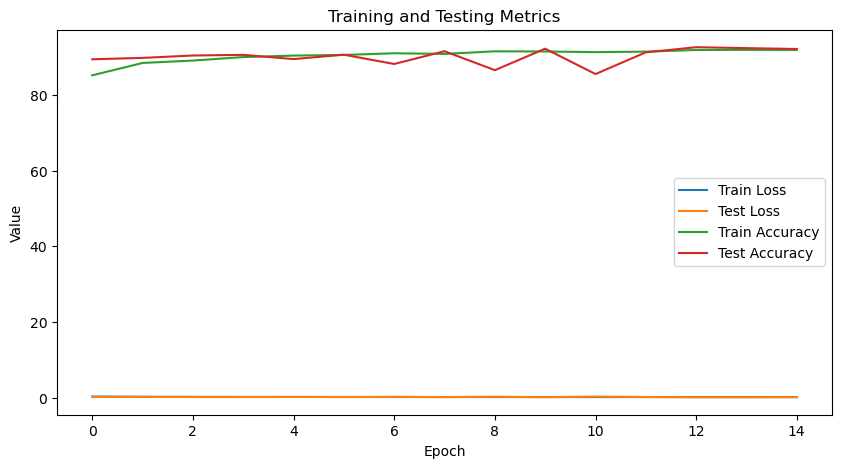

In [14]:
# Set the learning rate and number of epochs
n_epochs = 15

# Create the model
model = SymmetricNet(0.5).to(device)

# Set up the optimizer and criterion
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Train the model
train(model, trainLoader, testLoader, optimizer, criterion, n_epochs)

Code below makes it possible to save model

In [15]:
# Define the file path to save the trained model
# model_path = 'model.pth'

# Train and save the model
# train(model, train_loader, test_loader, optimizer, criterion, n_epochs)
# torch.save(model.state_dict(), model_path)

In [16]:
# # Define the file path to load the saved model
# model_path = 'model.pth'

# # Create an instance of the model and load the saved state dictionary
# model = SymmetricNet(dropout=0.25)
# model.load_state_dict(torch.load(model_path))